In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import ruptures as rpt

Import some jobs

In [2]:
import os, random
job_files = []
dataset_path = "C:\\Users\\a770398\\IO-SEA\\io-sea-3.4-analytics\\dataset_generation\\dataset_generation"
for root, dirs, files in os.walk(dataset_path):
    for csv_file in files:
        if csv_file.endswith(".csv"):
            job_files.append(os.path.join(root, csv_file))
        
# csv_file = os.path.join("C:\\Users\\a770398\IO-SEA\io-sea-3.4-analytics\\dataset_generation\\dataset_generation\\dataset_oth_db\\job_1272.csv")

csv_file = random.choice(job_files)
print(csv_file)



C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_genji_IOI_BD260919\job_507740.csv


Basic plot

array([[<AxesSubplot:xlabel='timestamp'>,
        <AxesSubplot:xlabel='timestamp'>,
        <AxesSubplot:xlabel='timestamp'>,
        <AxesSubplot:xlabel='timestamp'>]], dtype=object)

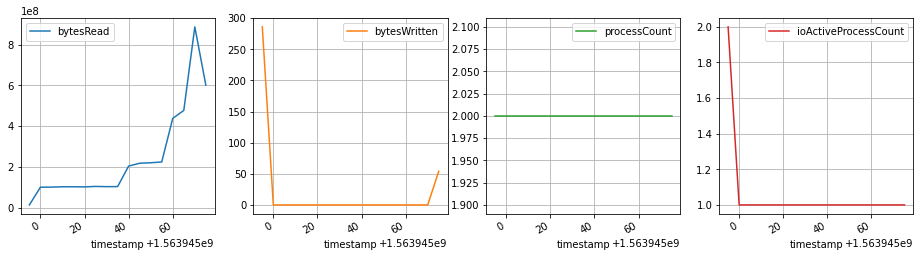

In [4]:
df = pd.read_csv(csv_file, index_col=0)
df.plot(x="timestamp", figsize=(16,4), sharex=True, grid=True, subplots=True, layout=(1, 4))
#df.head()

Now we apply some algos on the bidimensional signal (y1=["bytesRead"], y2=["bytesWritten"]

<AxesSubplot:>

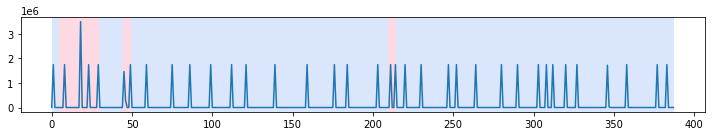

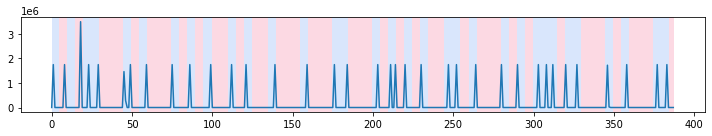

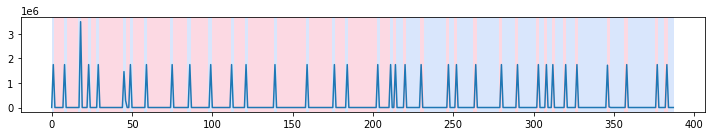

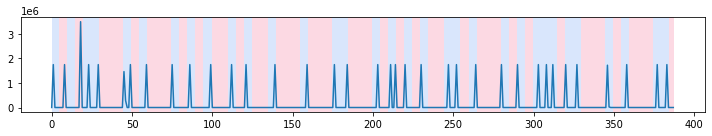

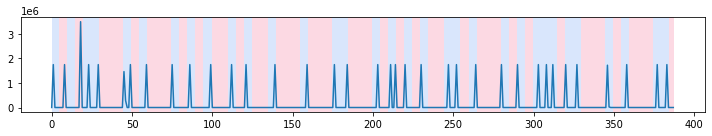

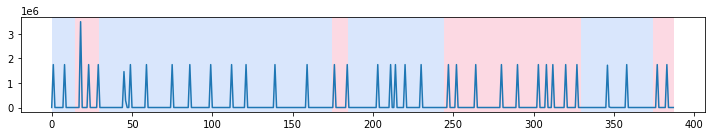

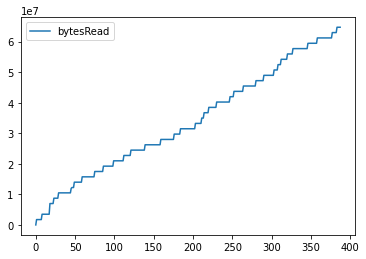

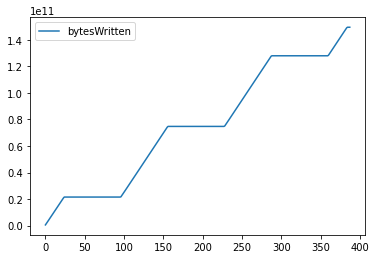

In [32]:
signal = df[["bytesRead"]].to_numpy()

dyn_result = rpt.Dynp(model="rbf").fit(signal).predict(n_bkps=6)
pelt_result = rpt.Pelt(model="rbf", min_size=3).fit(signal).predict(pen=0.1)
kcpd_result = rpt.KernelCPD(kernel="rbf").fit(signal).predict(pen=0.1) # a c implementation of dyn/pelt
binseg_result = rpt.Binseg(model="l2").fit(signal).predict(pen=0.1)
botup_result = rpt.BottomUp(model="l2").fit(signal).predict(pen=0.1)
wind_result = rpt.Window(model="l2", width=10).fit(signal).predict(pen=0.1)

rpt.display(signal, dyn_result)
rpt.display(signal, pelt_result)
rpt.display(signal, kcpd_result)
rpt.display(signal, binseg_result)
rpt.display(signal, botup_result)
rpt.display(signal, wind_result)

df[["bytesRead"]].cumsum().plot()
df[["bytesWritten"]].cumsum().plot()

Some biblio:
- https://arxiv.org/abs/2003.06222
- https://arxiv.org/pdf/1801.00718.pdf
- https://github.com/alan-turing-institute/TCPDBench
- https://www.youtube.com/watch?v=Sb89wJaCp7o&ab_channel=VideoLecturesChannel
- https://notebook.community/hildensia/bayesian_changepoint_detection/Example%20Code
- https://techrando.com/2019/08/14/a-brief-introduction-to-change-point-detection-using-python/
- https://schuetzgroup.github.io/sdt-python/changepoint.html
- https://centre-borelli.github.io/ruptures-docs/
- https://paperswithcode.com/task/change-point-detection
- https://github.com/YKatser/CPDE
- https://arxiv.org/pdf/2204.07403v1.pdf
- https://github.com/cruiseresearchgroup/TSCP2

Estimating cost value

In [1]:
def choose_random_job(dataset_path = "C:\\Users\\a770398\\IO-SEA\\io-sea-3.4-analytics\\dataset_generation\\dataset_generation"):
    job_files = []    
    for root, dirs, files in os.walk(dataset_path):
        for csv_file in files:
            if csv_file.endswith(".csv"):
                job_files.append(os.path.join(root, csv_file))
    return random.choice(job_files)

array([[<AxesSubplot:xlabel='timestamp'>,
        <AxesSubplot:xlabel='timestamp'>,
        <AxesSubplot:xlabel='timestamp'>,
        <AxesSubplot:xlabel='timestamp'>]], dtype=object)

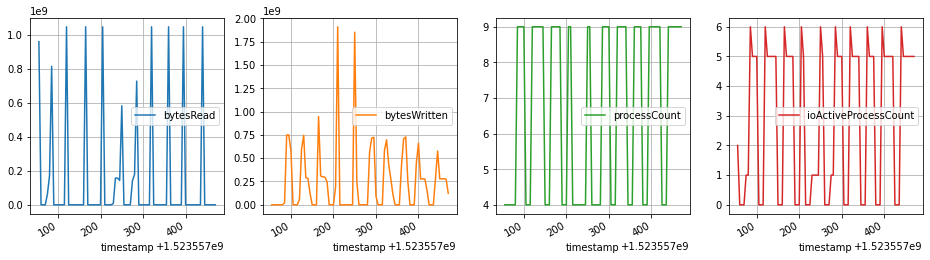

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import ruptures as rpt
import os, random
csv_file = choose_random_job()
df = pd.read_csv(csv_file, index_col=0)
df.plot(x="timestamp", figsize=(16,4), sharex=True, grid=True, subplots=True, layout=(1, 4))

[5, 10, 15, 20, 25, 30, 35, 45, 50, 65]
7917733834.0
compute= [0, 5, 10, 15, 20, 25] -- write = [0, 143126772.5, 14050882.5, 469167.5, 1863065.0]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
9.750829476416205e+18
compute= [0, 5, 10, 15, 20, 25, 30] -- write = [0, 143126772.5, 14050882.5, 469167.5, 698835.0, 23758002145.0, 5368835200.0]
[65]
2595.087716931191
compute= [0] -- write = [0]
[20, 65]
1.5163377959432022e+19
compute= [0, 20] -- write = [0]


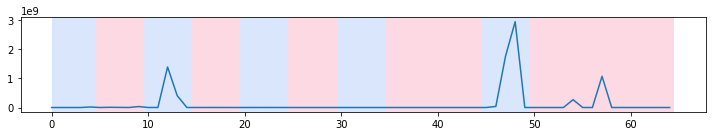

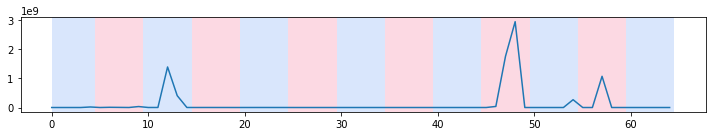

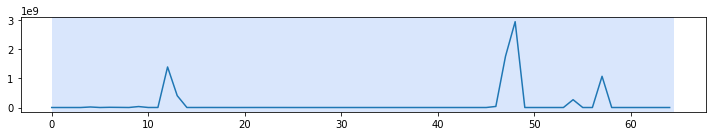

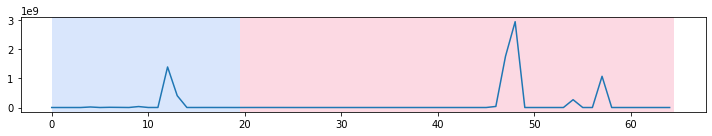

In [41]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

signal = df[["bytesWritten"]].to_numpy()
for cost in [rpt.costs.CostL1(), rpt.costs.CostL2(), rpt.costs.CostNormal(), rpt.costs.CostLinear()]:
             #rpt.costs.CostAR(order=10), rpt.costs.CostMl(metric=np.eye(1)), rpt.costs.CostRank()]:
    result = rpt.Pelt(custom_cost=cost).fit(signal).predict(pen=1000)
#pelt_result = rpt.Pelt(model="rbf", min_size=3).fit(signal).predict(pen=0.1)
#print(cost.fit(signal).error(0, len(signal)))
    print("===================")
    rpt.display(signal, result)
    print(result)
    print(cost.sum_of_costs(result))
    
    # reconstruction loop:
    compute = [0]
    write = [0]
    bandwidth = [0]
    closing_point = 0
    for i_brkpt, brkpt in enumerate(result[:-1]):
        if (i_brkpt % 2) == 0: # starting point
            starting_point = brkpt
            compute.append(compute[-1] + (starting_point - closing_point))
        if (i_brkpt %2) != 0: # closing point
            closing_point = brkpt
            phase_volume = integrate.trapz(y=signal[starting_point: closing_point].flatten(), dx=5)
            write.append(phase_volume)
            
    print(f"compute= {compute} -- write = {write}")
        
            
            

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ruptures as rpt
import os, random, time

# choose a job
def list_jobs(dataset_path = "C:\\Users\\a770398\\IO-SEA\\io-sea-3.4-analytics\\dataset_generation\\dataset_generation"):
    job_files = []
    job_ids = []
    dataset = []
    for root, dirs, files in os.walk(dataset_path):
        for csv_file in files:
            if csv_file.endswith(".csv"):
                job_files.append(os.path.join(root, csv_file))
                job_ids.append(csv_file.split("_")[-1].split(".csv")[0])
                dataset.append(os.path.split(root)[-1])
    return job_files, job_ids, dataset
job_files, job_ids, datasets = list_jobs()


Benchmarking offline algos

In [4]:
df = pd.DataFrame(columns=["dataset", "jobid", "timeserie", "signal_length", "n_brkpts",
                           "algo_name", "cost_function", "loss", "penalty", "computation_time"])

job_files, job_ids, datasets = list_jobs()
for job_file, job_id, dataset in zip(job_files[0:2], job_ids[0:2], datasets[0:2]):
    df_signal = pd.read_csv(job_file, index_col=0)
    for ts in ["bytesWritten", "bytesRead"]:
        signal = df_signal[[ts]].to_numpy()
        signal_dim = signal.shape[1]

        # define costs
        costs = [rpt.costs.CostL1(), rpt.costs.CostL2(), rpt.costs.CostNormal(), rpt.costs.CostLinear(),
                rpt.costs.CostCLinear(), rpt.costs.CostAR(order=3), rpt.costs.CostMl(metric=np.eye(signal_dim)), rpt.costs.CostRank()]
        costs_names = ["L1", "L2", "Gauss", "Linear", "Clinear", "AR", "Mala", "Rank"]

        # algos = [rpt.Pelt(custom_cost=cost, min_size=2), rpt.Binseg(custom_cost=cost),
        #          rpt.BottomUp(custom_cost=cost), rpt.Window(custom_cost=cost, width=10)]

        algos = [rpt.Pelt, rpt.Binseg, rpt.BottomUp, rpt.Window]

        algos_names = ["Pelt", "Binseg", "Botup", "Wind"]

        penalties = np.logspace(-3, 3, num=6).tolist()
# ["dataset", "jobid", "timeserie", "signal_length", "n_brkpts",
#                            "algo_name", "cost_function", "loss", "penalty", "computation_time"]
        for algo, algo_name in zip(algos[0:2], algos_names[0:2]):
            for cost, costs_name in zip(costs[0:2], costs_names[0:2]):
                for pen in penalties[0:2]:
                    try:
                        start_time = time.time()
                        result = algo(custom_cost=cost, min_size=2).fit_predict(signal, pen)
                        duration = time.time() - start_time
                        n_brkpts = len(result) - 1
                        loss = cost.sum_of_costs(result)
                        df = df.append({"dataset": dataset,
                                        "jobid": job_id,
                                        "timeserie": ts,
                                        "signal_length": signal.shape[0],
                                        "n_brkpts": n_brkpts,
                                        "algo_name": algo_name,
                                        "cost_function": costs_name,
                                        "loss": loss,
                                        "penalty": pen,
                                        "computation_time": duration,
                                        },
                                    ignore_index=True)
                    except:
                        pass
                
df.to_csv("_".join(algos_names) + "_bench.csv")

c:\Users\a770398\AppData\Local\Continuum\anaconda3\envs\iosea-venv\lib\site-packages\ruptures\costs\costnormal.py:28: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


In [10]:
df.head()

,dataset,jobid,timeserie,signal_length,n_brkpts,algo_name,cost_function,loss,penalty,computation_time
0,dataset_genji_IOI_BD260919,457344,bytesWritten,2758,352,Pelt,L1,1.508271e+10,0.001000,5.332779
1,dataset_genji_IOI_BD260919,457344,bytesWritten,2758,352,Pelt,L1,1.508271e+10,0.015849,4.827626
2,dataset_genji_IOI_BD260919,457344,bytesWritten,2758,455,Pelt,L2,5.433672e+18,0.001000,0.607126
3,dataset_genji_IOI_BD260919,457344,bytesWritten,2758,455,Pelt,L2,5.433672e+18,0.015849,0.790262
4,dataset_genji_IOI_BD260919,457344,bytesWritten,2758,1,Binseg,L1,1.764660e+10,0.001000,0.688007


Measure the reconstruction distance